In [27]:
import pandas as pd
import numpy as np
import seaborn as sb
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv('Xtrain.csv')
df_y = pd.read_csv('Ytrain.csv')
df = pd.concat([df, df_y['ChargeOff']], axis=1, sort=False)
df = df.drop(['Name', 'City', 'Zip', 'BankState', 'Bank'], axis= 1)

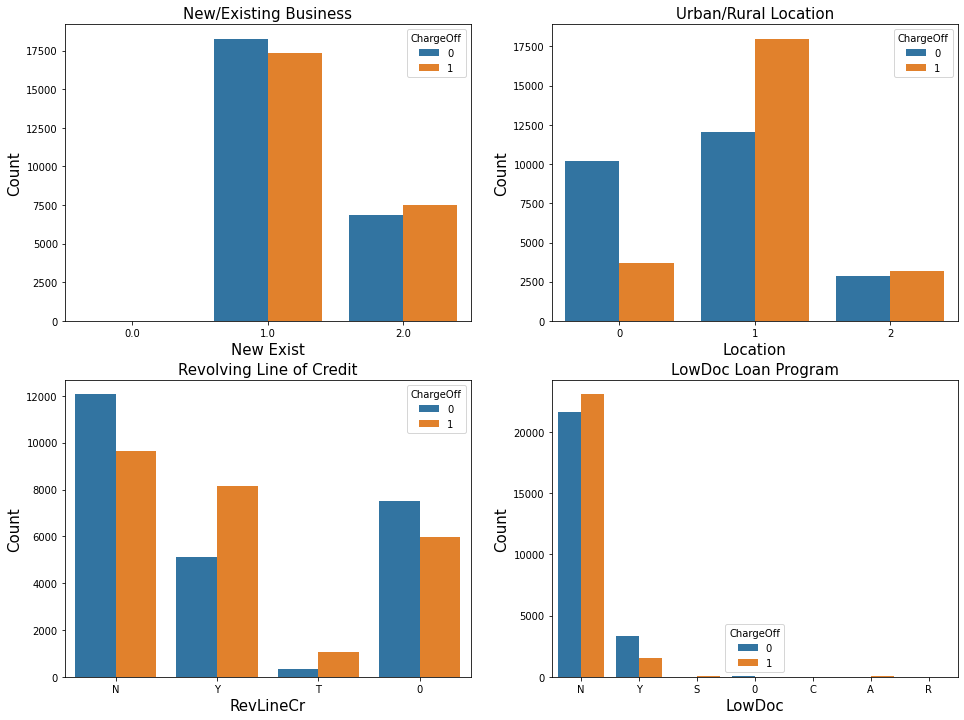

In [59]:
# NewExist column
_, axes = plt.subplots(2, 2, figsize=(16,12))

sb.countplot(x = "NewExist", hue = "ChargeOff", data = df, ax=axes[0, 0])
axes[0, 0].set_title('New/Existing Business', fontsize=15)
axes[0, 0].set_xlabel('New Exist', fontsize=15)
axes[0, 0].set_ylabel('Count', fontsize=15)

sb.countplot(x = "UrbanRural", hue = "ChargeOff", data = df, ax=axes[0, 1])
axes[0, 1].set_title('Urban/Rural Location', fontsize=15)
axes[0, 1].set_xlabel('Location', fontsize=15)
axes[0, 1].set_ylabel('Count', fontsize=15)

sb.countplot(x = "RevLineCr", hue = "ChargeOff", data = df, ax=axes[1, 0])
axes[1, 0].set_title('Revolving Line of Credit', fontsize=15)
axes[1, 0].set_xlabel('RevLineCr', fontsize=15)
axes[1, 0].set_ylabel('Count', fontsize=15)

sb.countplot(x = "LowDoc", hue = "ChargeOff", data = df, ax=axes[1, 1])
axes[1, 1].set_title('LowDoc Loan Program', fontsize=15)
axes[1, 1].set_xlabel('LowDoc', fontsize=15)
axes[1, 1].set_ylabel('Count', fontsize=15)

plt.show()